In [24]:
import numpy as np
import nibabel as nib

#Define the path to your dataset
TRAIN_DATASET_PATH = 'BraTS-Africa/95_Glioma'

#Load sample images and visualize
image_t1n = nib.load(TRAIN_DATASET_PATH + '/BraTS-SSA-00008-000/BraTS-SSA-00008-000-t1n.nii.gz').get_fdata()
image_t1c = nib.load(TRAIN_DATASET_PATH + '/BraTS-SSA-00008-000/BraTS-SSA-00008-000-t1c.nii.gz').get_fdata()
image_t2f = nib.load(TRAIN_DATASET_PATH + '/BraTS-SSA-00008-000/BraTS-SSA-00008-000-t2f.nii.gz').get_fdata()
image_t2w = nib.load(TRAIN_DATASET_PATH + '/BraTS-SSA-00008-000/BraTS-SSA-00008-000-t2w.nii.gz').get_fdata()
mask = nib.load(TRAIN_DATASET_PATH + '/BraTS-SSA-00008-000/BraTS-SSA-00008-000-seg.nii.gz').get_fdata()


In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
 
image_t1n = scaler.fit_transform(image_t1n.reshape(-1,image_t1n.shape[-1])).reshape(image_t1n.shape)
image_t1c = scaler.fit_transform(image_t1c.reshape(-1,image_t1c.shape[-1])).reshape(image_t1c.shape)
image_t2f=scaler.fit_transform(image_t2f.reshape(-1,image_t2f.shape[-1])).reshape(image_t2f.shape)
image_t2w = scaler.fit_transform(image_t2w.reshape(-1,image_t2w.shape[-1])).reshape(image_t2w.shape)


In [26]:
mask = mask.astype(np.uint8)
mask[mask== 4] = 3 # Reassign mask values 4 to 3

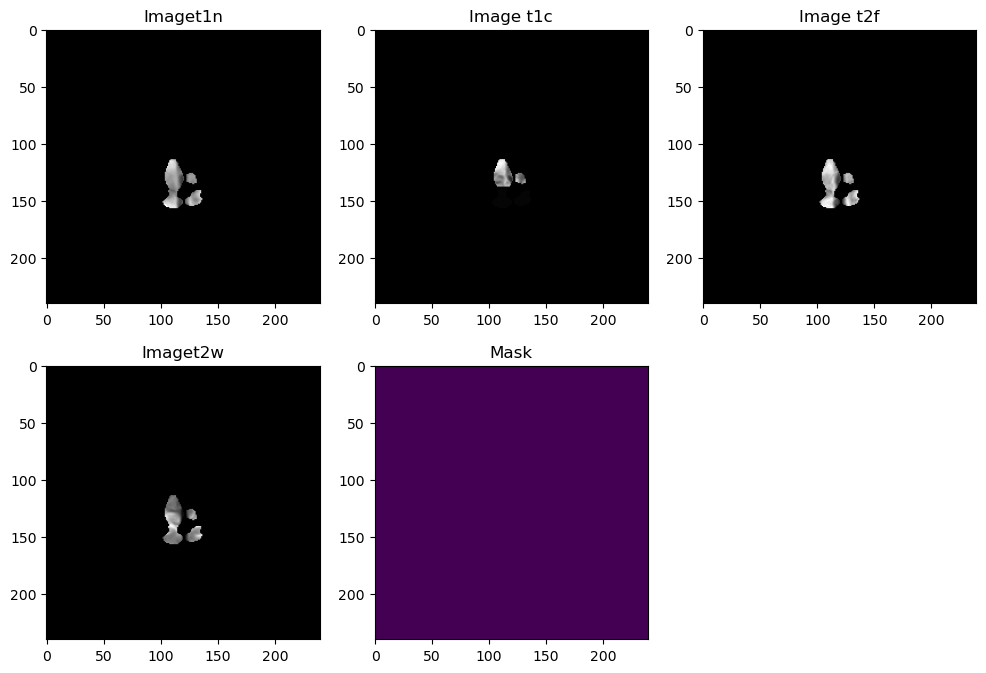

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import random

n_slice = random.randint(0, mask.shape[2]) #this picks random slice for viewing

plt.figure(figsize=(12,8))

plt.subplot(231)
plt.imshow(np.rot90(image_t1n[:,:, n_slice]), cmap='gray')
plt.title('Imaget1n')

plt.subplot(232)
plt.imshow(np.rot90(image_t1c[:,:, n_slice]), cmap='gray')
plt.title('Image t1c')

plt.subplot(233)
plt.imshow(np.rot90(image_t2f[:,:, n_slice]), cmap='gray')
plt.title('Image t2f')

plt.subplot(234)
plt.imshow(np.rot90(image_t2w[:,:, n_slice]), cmap='gray')
plt.title('Imaget2w')

plt.subplot(235)
plt.imshow(np.rot90(mask[:,:, n_slice]))
plt.title('Mask')

plt.show()

**Combining Multi-Modality Images**

 Brain MRI scans often include multiple modalities (e.g., T1, T2, FLAIR), each providing complementary information. We combine these modalities into a single multi-channel NumPy array for input to the model.  

In [28]:
combined_x = np.stack([image_t1n, image_t1c, image_t2f, image_t2w], axis=3)

 **Cropping the Images** 
 
To reduce computational load, we crop the images to a smaller size (from 256x256x256 to 128x128x128). This step ensures the data fits into memory and is compatible with the model architecture.  

In [29]:
combined_x = combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128
mask = mask[56:184, 56:184, 13:141]

**Processing the Entire Dataset**

The above steps are repeated for all images in the dataset. We use `glob` to locate all `.nii.gz` files and process them in a loop.  A 1% threshold was applied to screen out images with less tumor-related images (1,  2, or 3), if too much background label (0) is found, it is removed from the images. The images are finally saved into a folder “glioma”.


In [30]:
import glob
import os
import nibabel as nib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

# Initialize scaler
scaler = MinMaxScaler()

# Create output folders
os.makedirs('glioma/images', exist_ok=True)
os.makedirs('glioma/masks', exist_ok=True)

# List all patient folders
patient_folders = glob.glob(os.path.join(TRAIN_DATASET_PATH, '*'))

# Loop over each patient folder
for img, folder in enumerate(patient_folders):
    # Construct paths
    t1n_path = glob.glob(os.path.join(folder, '*t1n.nii.gz'))
    t1c_path = glob.glob(os.path.join(folder, '*t1c.nii.gz'))
    t2f_path = glob.glob(os.path.join(folder, '*t2f.nii.gz'))
    t2w_path = glob.glob(os.path.join(folder, '*t2w.nii.gz'))
    mask_path = glob.glob(os.path.join(folder, '*seg.nii.gz'))

    # Check if all required files are present
    if not (t1n_path and t1c_path and t2f_path and t2w_path and mask_path):
        print(f"[SKIP] Missing modalities or mask in folder: {folder}")
        continue

    print("Now preparing image and masks number:", img)

    # Load and scale modalities
    def load_and_scale(img_path):
        img_data = nib.load(img_path[0]).get_fdata()
        img_data = scaler.fit_transform(img_data.reshape(-1, img_data.shape[-1])).reshape(img_data.shape)
        return img_data

    try:
        temp_image_t1n = load_and_scale(t1n_path)
        temp_image_t1c = load_and_scale(t1c_path)
        temp_image_t2f = load_and_scale(t2f_path)
        temp_image_t2w = load_and_scale(t2w_path)

        temp_mask = nib.load(mask_path[0]).get_fdata()
        temp_mask = temp_mask.astype(np.uint8)
        temp_mask[temp_mask == 4] = 3 # Reassign mask value 4 to 3

        
        # Combine modalities
        temp_combined_images = np.stack([temp_image_t1n, temp_image_t1c, temp_image_t2f, temp_image_t2w], axis=3)

        # Crop to desired shape
        temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
        temp_mask = temp_mask[56:184, 56:184, 13:141]

        val, counts = np.unique(temp_mask, return_counts=True)

        if len(counts) > 1 and (1 - (counts[0] / counts.sum())) > 0.01:
            print("Save Me")
            temp_mask = to_categorical(temp_mask, num_classes=4)
            np.save(f'glioma/images/image_{img}.npy', temp_combined_images)
            np.save(f'glioma/masks/mask_{img}.npy', temp_mask)
        else:
            print("I am not a good addition to the model")
    except Exception as e:
        print(f"[ERROR] Failed to process {folder}: {e}")
        continue

Now preparing image and masks number: 0
Save Me
Now preparing image and masks number: 1
Save Me
Now preparing image and masks number: 2
Save Me
Now preparing image and masks number: 3
Save Me
Now preparing image and masks number: 4
Save Me
Now preparing image and masks number: 5
Save Me
Now preparing image and masks number: 6
Save Me
Now preparing image and masks number: 7
Save Me
Now preparing image and masks number: 8
Save Me
Now preparing image and masks number: 9
Save Me
Now preparing image and masks number: 10
Save Me
Now preparing image and masks number: 11
Save Me
Now preparing image and masks number: 12
Save Me
Now preparing image and masks number: 13
Save Me
Now preparing image and masks number: 14
Save Me
Now preparing image and masks number: 15
I am not a good addition to the model
Now preparing image and masks number: 16
Save Me
Now preparing image and masks number: 17
Save Me
Now preparing image and masks number: 18
Save Me
Now preparing image and masks number: 19
Save Me


**Data Splitting**
The dataset is split into training, validation, and test sets using the `splitfolders` library. This ensures a balanced distribution of data across the sets. The split datasets were saved in a folder “glioma split data”.

In [31]:
!pip install split-folders


In [32]:
import splitfolders
import os

os.makedirs('glioma split data', exist_ok=True)

input_folder = 'glioma/'
output_folder = 'glioma split data/'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .15, .10), group_prefix=None)